In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Results: Right Insula

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk",style='whitegrid')
import pandas as pd
import numpy as np
np.random.seed(42)
import tensorflow as tf

import os

from src.preprocess.dataset import *
from src.models.model_selection import classifier

import plotly
import plotly.graph_objs as go

import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting
%matplotlib inline

## Load right ventro-anterior insula mask 
mask= nil.image.load_img('../../data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz')
rvAI = np.zeros_like(mask.get_fdata())
rvAI[np.logical_or(mask.get_fdata() == 230,mask.get_fdata() == 231)] = 1
rvAI_img = nil.image.new_img_like(mask,rvAI)

plot_glass_brain(rvAI_img)

Another GRU model with the same architecture, but slightly different hyperparameters,  was trained using segments only from the right Insula instead of whole brain. Following are the results.

## Search Grid With 5-fold Cross Validation

The model was fine tuned by finding optimal values for the following hyperparmeters:1) `L2` regularization and 2) `dropout` rate applied to each of the hidden layers, and 3) `learning_rate` of the Adam optimizer.

Optimal hyperparameters were found by doing a full grid-search over 20 combinations of hyperparameteres, and cross-validating each combination with a nested 5-fold cross-validation method. A total of 20 models were trained and validated. Following plot shows the performance of each model in terms of its training and validation accuracies. The models are shown in the descending order of their mean validation accuracy. The error bars indicate standard deviation across folds.

In [2]:
with open("../../results/03-rAI/grid_search20.pkl","rb") as file:
    results, param_grid = pickle.load(file)

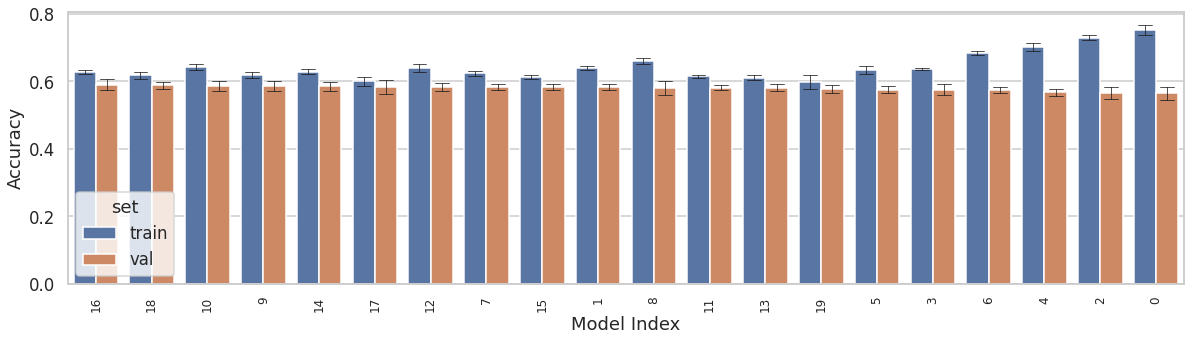

In [3]:
table = pd.DataFrame.from_dict({(i,j,k): results[i][j][k] for i in results.keys() for j in results[i].keys() for k in results[i][j].keys()}).T
table.reset_index(inplace=True)
table.rename(columns={'level_0':'model','level_1':'fold','level_2':'set',0:'acc'},inplace=True)

table['mod_num'] = table.model.str[5:].astype(int)
order = table[table['set']=='val'].groupby('mod_num')['acc'].mean().sort_values(ascending = False).index
plt.figure(figsize=(20,5))
sns.barplot(x='mod_num',y='acc',hue='set',ci='sd',data=table,
            palette=['C0','C1'],order=order,errwidth=0.75,
            errcolor='k',capsize=0.25)
plt.xticks(rotation=90,fontsize=12)
plt.xlabel('Model Index')
_=plt.ylabel('Accuracy')

Best performing model yielded mean training and validation accuracies of 0.63 and 0.59, respectively. Its hyperparameters were: 1) L2 = 0.003, dropout = 0.3, and learning_rate = 0.006.

In [5]:
# load data
dataset = Dataset('../../data/processed/03a-segments_normWithinSubjRun_rAI.pkl')
dataset.load()
dataset_df = organize_dataset(selective_segments(dataset.data,None))
dataset.train_test_split_sid()

In [6]:
X_train, y_train = query_dataset(dataset_df,dataset.train_idx)
X_test, y_test = query_dataset(dataset_df,dataset.test_idx)

model = tf.keras.models.load_model('../../models/03-rAI/CustomGRU.h5')
model.evaluate(X_test,y_test)

54/54 [==============================] - 1s 10ms/step - loss: 0.7322 - acc: 0.6055


[0.7321519255638123, 0.6054816842079163]

In [13]:
from collections import defaultdict
from sklearn.metrics import accuracy_score

test_acc = defaultdict(dict)
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    X_test, y_test = query_dataset(dataset_df,[subj_idx])
    y_pred = np.squeeze(model.predict_classes(X_test))
    for tp in range(X_test.shape[1]):
        test_acc[subj]['TP{:02d}'.format(tp)] = accuracy_score(y_test,y_pred[:,tp])
    loss, acc = model.evaluate(X_test,y_test)
    test_acc[subj]['overall'] = acc

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
3/3 [==============================] - 0s 5ms/step - loss: 0.8214 - acc: 0.4613


## Probability of predicting the true class as a function of time

Following figure shows probability of predicting the true class as a function of time. The probability of predicting the true class increases with time.

In [30]:
## get probabilities for appraoch segments on X_test
prob_df = pd.DataFrame(columns=['Subj','Timepoint','class','prob'])
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    for direction, k_class in zip(['appr','retr'],[1.,0.]):
        X_test, y_test = query_dataset(dataset_df,[subj_idx])
        X_test, y_test = X_test[y_test==k_class], y_test[y_test==k_class]
        if k_class == 1.:
            temp_df = pd.DataFrame(np.squeeze(model.predict(X_test)))
        else:
            temp_df = pd.DataFrame(1-np.squeeze(model.predict(X_test)))
        temp_df['Subj'] = subj
        temp_df['class'] = direction
        temp_df = temp_df.melt(id_vars=['Subj','class'],var_name='Timepoint',value_name='prob')
        prob_df = pd.concat([prob_df,temp_df],axis=0, ignore_index=True)

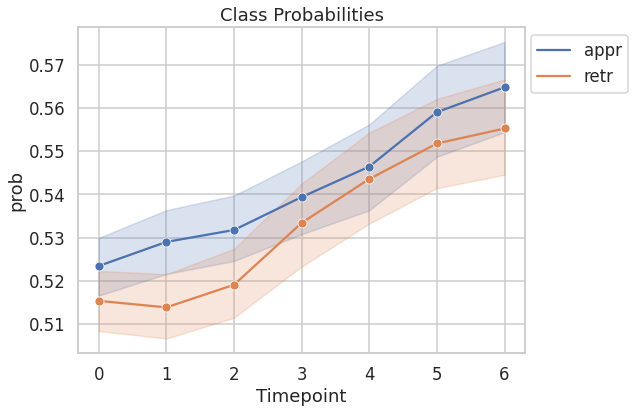

In [32]:
plt.figure(figsize=(8,6))
sns.lineplot(x='Timepoint',y='prob',hue='class',data=prob_df,
             ci=95, markers=True,marker='o',dashes=False,
             hue_order=['appr','retr'],palette=['C0','C1'])
plt.legend(loc='upper right',bbox_to_anchor=(1.25,1))
_=plt.title('Class Probabilities')

## Test Accuracy

The trained model was tested on the near-miss segments of the 19 held-out participants. Following figure shows temporal and overall accuracies on the held-out participants. The model performs resonably well from the 1st timepoint (TP) itself, with a mean accuracy of __0.58__. The mean accuracy steadily increases to __0.63__ by the 7th TP. "Overall" accuracy is the mean accuracy across TP, which is __0.603__.  

In [33]:
test_acc_df = pd.DataFrame(columns=['Subj','Timepoint','Accuracy'])
for SUB in test_acc:
    for TP in test_acc[SUB]:
        temp_df = pd.DataFrame([SUB, TP, test_acc[SUB][TP]], index=['Subj','Timepoint','Accuracy']).T
        test_acc_df = pd.concat([test_acc_df,temp_df],axis=0,ignore_index=True)
        
test_acc_df['Accuracy'] = test_acc_df['Accuracy'].astype(float)

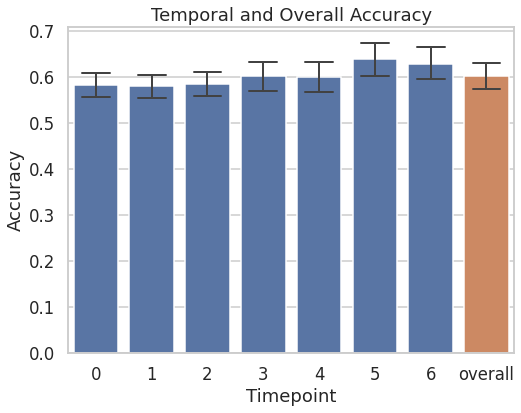

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(x='Timepoint',y='Accuracy',data=test_acc_df,ci=95,palette=['C0']*7+['C1'],errwidth=2,capsize=0.5)
plt.xticks(ticks=np.arange(8),labels=list(range(7))+['overall'])
_=plt.title('Temporal and Overall Accuracy')

## Chance Accuracy

To assess significance of the model performance, the observed test accuracy was compared against the accuracy that would be observed if the model was to guess one of the two classes at random. To that end, model with the best hyperparameter settings was trained on the training set a hundred times, each time with randomly shuffled labels. At every iteration, the model was tested on the test set with "non-shuffled" (i.e., true) labels. This process was meant to simulate a chance accuracy distribution. The mean of the chance accuracy distribution formed the baseline performance measure against the observed performance of the model when trained on true labels. The observed test accuracy was significantly greater than the average chance accuracy (p < 0.009). See the figure below.

In [41]:
with open('../../results/03-rAI/perm_acc.pkl',"rb") as f:
    obs_acc, results_perm = pickle.load(f)

Accuracy
Observed: 0.61
Chance: 0.50
Observed > Chance (p = 0.0099)


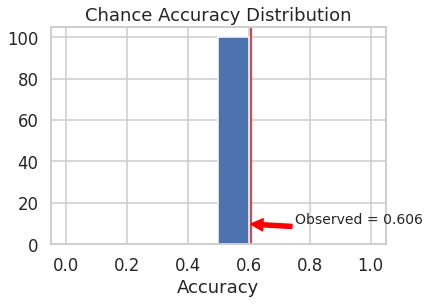

In [47]:
plt.hist(results_perm['val'],bins=int(np.sqrt(len(results_perm['val']))))
plt.axvline(obs_acc['obs_test_acc'],c='r',label=None)
plt.xlabel('Accuracy')
plt.title('Chance Accuracy Distribution')
_=plt.annotate('Observed = %.3f' %(obs_acc['obs_test_acc']),
               xy=(obs_acc['obs_test_acc'],9.75),
               xytext=(0.75,10),
               arrowprops={'color':'red'},
               fontsize=14)
p_val = (np.sum(np.array(results_perm['val']) > obs_acc['obs_test_acc'])+1)/(len(results_perm['val'])+1)
print('Accuracy')
print('Observed: %.2f'%obs_acc['obs_test_acc'])
print('Chance: %.2f'%np.mean(results_perm['val']))
print('Observed > Chance (p = %.4f)' %(p_val))

## Temporal Trajectories

GRU outputs hidden states that are typically high dimensional. Hidden states ($h_{t}$) capture spatio-temporal variance that is most useful in maintaning class separability. To visualize dynamics, $h_{t}$ was linearly projected onto a lower (3D) dimensional space, $\hat{h_{t}}$. This was done by replacing the output layer with a _Dimensionality Reduction Dense Layer (DRDL)_ with three linear units. In essence, this is a supervised non-linear dimensional reduction step. 



<img src="../../support/images/DRDL.png" alt="Dimensionality Reduction Dense Layer" width="300"/>



The 3-dimensional representations of $h_{t}$ ($\hat{h_{t}}$) for both stimulus class are plotted along the three axes of the coordinate system below. The plot represents the temporal trajectories of the two classes. At the first timepoint the two classes are closest to each other. Distance between them increases with every timepoint. Next plot shows the Euclidean distance between the two classes as a function of time.

In [48]:
# Make a copy the model
# (tips: https://stackoverflow.com/questions/57316557/tf-keras-layers-pop-doesnt-work-but-tf-keras-layers-pop-does)
#tf.random.set_seed(50)
tf.random.set_seed(47)
BestModel = tf.keras.models.clone_model(model)
BestModel.set_weights(model.get_weights())

# Replace the the last Time-Distributed layer with Fully connected layer with only two units
BestModel = tf.keras.Sequential(BestModel.layers[:-1])

# add a new time-distributes dense layer with 2 units and 'linear' activation function
BestModel.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3,activation='linear')))

# Set trainable = False for the layers from BestModel
for layers in BestModel.layers:
    layers.trainable = False

BestModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 16)          36624     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
gru_2 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           51        
Total params: 39,939
Trainable params: 0
Non-trainable params: 39,939
_________________________________________________________________


In [49]:
trajectory = {}
for subj_idx in dataset.test_idx:
    subj = dataset.sid()[subj_idx]
    X_test, y_test = query_dataset(dataset_df,[subj_idx])
    y_pred = BestModel.predict(X_test,)
    appr = y_pred[y_test==1.,:,:].mean(axis=0)
    retr = y_pred[y_test==0.,:,:].mean(axis=0)
    trajectory[subj] = {'Approach':{'x1':list(appr[:,0]),'x2':list(appr[:,1]),'x3':list(appr[:,2])},
                        'Retreat':{'x1':list(retr[:,0]),'x2':list(retr[:,1]),'x3':list(retr[:,2])}}

In [50]:
trajectory_df = pd.DataFrame.from_dict({(i,j,k): trajectory[i][j][k] 
                                        for i in trajectory.keys() 
                                        for j in trajectory[i].keys() 
                                        for k in trajectory[i][j].keys()}).T
trajectory_df = trajectory_df.stack().unstack(2).stack()
trajectory_df = trajectory_df.to_frame(name='trajectory')
trajectory_df.reset_index(inplace=True)
trajectory_df.rename(columns={'level_0':'Subj','level_1':'Direction','level_2':'TP','level_3':'axis'},inplace=True)
trajectory_df = trajectory_df.groupby(['Direction','TP','axis'])['trajectory'].mean().unstack(-1).reset_index()

In [51]:
approach_x1 = trajectory_df[trajectory_df['Direction']=='Approach']['x1']
approach_x2 = trajectory_df[trajectory_df['Direction']=='Approach']['x2']
approach_x3 = trajectory_df[trajectory_df['Direction']=='Approach']['x3']

retreat_x1 = trajectory_df[trajectory_df['Direction']=='Retreat']['x1']
retreat_x2 = trajectory_df[trajectory_df['Direction']=='Retreat']['x2']
retreat_x3 = trajectory_df[trajectory_df['Direction']=='Retreat']['x3']

In [52]:
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure trace for approach.
appr = go.Scatter3d(
    x=approach_x1,  # <-- Put your data instead
    y=approach_x2,  # <-- Put your data instead
    z=approach_x3,  # <-- Put your data instead
    mode='lines+markers',
    marker={
        'size': 8,
        'opacity': 0.8,
        'color':'red'
    },
    name='Approach'
)

retr = go.Scatter3d(
    x=retreat_x1,  # <-- Put your data instead
    y=retreat_x2,  # <-- Put your data instead
    z=retreat_x3,  # <-- Put your data instead
    mode='lines+markers',
    marker={
        'size': 8,
        'opacity': 0.8,
        'color':'green'
    },
    name='Retreat'
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [appr,retr]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
#plotly.offline.iplot(plot_figure)
# (tip: https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook)
plotly.offline.plot(plot_figure, filename = 'figures/trajectories.html', config = None)
display(HTML('figures/trajectories.html'))

In [53]:
# Calculate Euclidean distance between approach and retreat trajectories.
approach_dim3 = np.stack([approach_x1,approach_x2,approach_x3],axis=1)
retreat_dim3 = np.stack([retreat_x1,retreat_x2,retreat_x3],axis=1)
traj_dim3 = np.stack([approach_dim3,retreat_dim3])

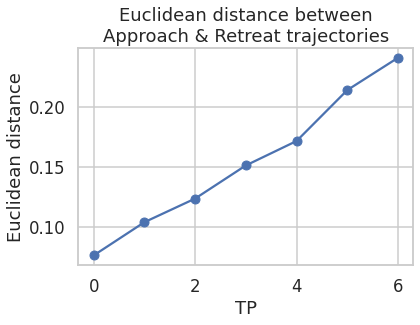

In [54]:
plt.plot(np.squeeze(np.linalg.norm(np.diff(traj_dim3,axis=0),
                                     axis=2)),marker='o')
plt.xlabel('TP')
plt.ylabel('Euclidean distance')
_=plt.title('Euclidean distance between\nApproach & Retreat trajectories')

## Saliency Map 
Source: https://pypi.org/project/tf-keras-vis/